### Importing package

In [1]:
# Libraries
import time
import re

# Reading in files
import pandas as pd
import numpy as np
import pickle
import gzip

# Progress bar
from tqdm.auto import tqdm

# Torch modules
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast as AutoTokenizer, AutoModel, AdamW, get_linear_schedule_with_warmup

# Lightning modules
import pytorch_lightning as pl
from torchmetrics.functional import accuracy, auroc
from torchmetrics import F1Score
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassPrecision, MulticlassRecall

# Split dataset/validation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix
from sklearn.model_selection import StratifiedKFold

# Importing own functions 
from importing_data import get_section_json

C:\Users\Benjamin Aw\anaconda3\envs\myenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with gzip.open("data/acl-publication-info.74k.v2.full-sections.pkl", "rb") as f:
    df = pickle.load(f, encoding='bytes')

In [3]:
df = df.reset_index()

In [4]:
df["Intro_concl"] = df['json_contents'].progress_apply(get_section_json, args = [["introduction", "conclusion"]])

100%|█████████████████████████████████████████████████████████████████████████| 67732/67732 [00:01<00:00, 65441.68it/s]


In [5]:
df2 = pd.json_normalize(df['Intro_concl'])

In [6]:
df["Intro_concl_concat"] = df2['Introduction'] + df2['Conclusion'] 

In [7]:
df["Year Published"] = df["ID"].apply(lambda x: re.search("\d{4}", x).group(0))

In [8]:
df

,index,acl_id,abstract,full_text,corpus_paper_id,pdf_hash,numcitedby,url,publisher,address,...,editor,isbn,ENTRYTYPE,ID,language,note,json_contents,Intro_concl,Intro_concl_concat,Year Published
0,2,R13-1042,Thread disentanglement is the task of separati...,Thread disentanglement is the task of separati...,16703040,3eb736b17a5acb583b9a9bd99837427753632cdb,10,https://aclanthology.org/R13-1042,"INCOMA Ltd. Shoumen, BULGARIA","Hissar, Bulgaria",...,None,None,inproceedings,jamison-gurevych-2013-headerless,None,None,"{'paper_id': 'R13-1042', 'header': {'generated...",{'Introduction': 'Law enforcement agencies fre...,Law enforcement agencies frequently obtain lar...,2013
1,3,W05-0819,"In this paper, we describe a word alignment al...","In this paper, we describe a word alignment al...",1215281,b20450f67116e59d1348fc472cfc09f96e348f55,15,https://aclanthology.org/W05-0819,Association for Computational Linguistics,"Ann Arbor, Michigan",...,None,None,inproceedings,aswani-gaizauskas-2005-aligning,None,None,"{'paper_id': 'W05-0819', 'header': {'generated...",{'Introduction': 'This paper describes a word ...,This paper describes a word alignment system d...,2005
2,5,R13-1044,The paper 1 presents a rule-based approach to ...,The paper 1 presents a rule-based approach to ...,2491460,c0f1047fe0f95c367184d494e78bb07b11ee3608,2,https://aclanthology.org/R13-1044,"INCOMA Ltd. Shoumen, BULGARIA","Hissar, Bulgaria",...,None,None,inproceedings,kedzia-maziarz-2013-recognizing,None,None,"{'paper_id': 'R13-1044', 'header': {'generated...",{'Introduction': 'Semantic relation recognitio...,Semantic relation recognition is a well-known ...,2013
3,6,W05-0818,"In this paper we describe LIHLA, a lexical ali...","In this paper we describe LIHLA, a lexical ali...",15322146,ff3f05120d24e5dac2879f25402993bc6355f780,5,https://aclanthology.org/W05-0818,Association for Computational Linguistics,"Ann Arbor, Michigan",...,None,None,inproceedings,caseli-etal-2005-lihla,None,None,"{'paper_id': 'W05-0818', 'header': {'generated...",{'Introduction': 'Alignment of words and multi...,Alignment of words and multiword units plays a...,2005
4,8,R13-1045,We describe an approach to building a morpholo...,We describe an approach to building a morpholo...,690455,0b125557ba23075532380e88fb990933838975b7,2,https://aclanthology.org/R13-1045,"INCOMA Ltd. Shoumen, BULGARIA","Hissar, Bulgaria",...,None,None,inproceedings,khaliq-carroll-2013-unsupervised,None,None,"{'paper_id': 'R13-1045', 'header': {'generated...",{'Introduction': 'The number and diversity of ...,The number and diversity of human languages ma...,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67727,73280,P99-1002,This paper describes recent progress and the a...,This paper describes recent progress and the a...,715160,ab17a01f142124744c6ae425f8a23011366ec3ee,11,https://aclanthology.org/P99-1002,Association for Computational Linguistics,"College Park, Maryland, USA",...,None,None,inproceedings,furui-1999-automatic,None,None,"{'paper_id': 'P99-1002', 'header': {'generated...",{'Introduction': 'The field of automatic speec...,The field of automatic speech recognition has ...,1999
67728,73281,P00-1009,We present an LFG-DOP parser which uses fragme...,We present an LFG-DOP parser which uses fragme...,1356246,ad005b3fd0c867667118482227e31d9378229751,12,https://aclanthology.org/P00-1009,Association for Computational Linguistics,Hong Kong,...,None,None,inproceedings,bod-2000-improved,None,None,"{'paper_id': 'P00-1009', 'header': {'generated...",{'Introduction': 'Data-Oriented Parsing (DOP) ...,Data-Oriented Parsing (DOP) models learn how t...,2000
67729,73282,P99-1056,The processes through which readers evoke ment...,The processes through which readers evoke ment...,7277828,924cf7a4836ebfc20ee094c30e61b949be049fb6,14,https://aclanthology.org/P99-1056,Association for Computational Linguistics,"College Park, Maryland, USA",...,None,None,inproceedings,lange-content-1999-grapho,None,None

### Importing classification model

In [9]:
train_df = pd.read_csv("./Data/Collated_dataset_for_scientific_papers.csv")

In [10]:
train_df = train_df[["Intro Concl", "Labels"]]

In [11]:
train_df.columns = ["string", "label"]

In [12]:
possible_labels = list(train_df['label'].unique())
possible_labels_num = list(range(0,len(possible_labels)))

In [13]:
MODEL_NAME = 'allenai/specter'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [14]:
mapping = zip(possible_labels, possible_labels_num)
label_to_idx = {label: num  for label, num in mapping}
mapping = zip(possible_labels, possible_labels_num)
idx_to_label = {num: label for label, num in mapping}

In [15]:
MAX_TOKEN_COUNT = 512
N_EPOCHS = 5
BATCH_SIZE = 8 # Changes: Edit the batch size here
KFOLD = 5

In [16]:
class SpecterDataset(Dataset):
    
    def __init__(self, data: pd.DataFrame, tokenizer: AutoTokenizer, max_token_len: int = MAX_TOKEN_COUNT, mapping = label_to_idx):
        self.tokenizer = tokenizer
        self.data = data
        self.max_token_len = max_token_len
        self.mapping = mapping
    
    def __len__(self):
        return len(self.data)
    
    
    def __getitem__(self, index: int):
    
        data_row = self.data.iloc[index]
        text = data_row["string"]
        labels = self.mapping[data_row["label"]]

        encoding = self.tokenizer.encode_plus(
          text,
          add_special_tokens=True,
          max_length=self.max_token_len,
          return_token_type_ids=False,
          padding="max_length",
          truncation=True,
          return_attention_mask=True,
          return_tensors='pt',
        )

        return dict(
          text=text,
          input_ids=encoding["input_ids"].flatten(),
          attention_mask=encoding["attention_mask"].flatten(),
          labels=labels
        )

In [17]:
class SpecterDataModule(pl.LightningDataModule):
    
    def __init__(self, df,
                 tokenizer,
                 k = 0,  # fold number
                 split_seed = 123,  # split needs to be always the same for correct cross validation
                 num_splits = KFOLD,
                 batch_size = BATCH_SIZE, 
                 max_token_len = MAX_TOKEN_COUNT,
                 num_workers = 0,
                 pin_memory = False):
        
        super().__init__()

        self.save_hyperparameters(logger=False)
    
    def setup(self, stage=None):

        # choose fold to train on
        kf = StratifiedKFold(n_splits=self.hparams.num_splits, shuffle=True, random_state=self.hparams.split_seed)
        all_splits = [k for k in kf.split(df, df.label)]
        train_indexes, val_indexes = all_splits[self.hparams.k]
        train_indexes, val_indexes = train_indexes.tolist(), val_indexes.tolist()

        self.data_train, self.data_val = df.iloc[train_indexes], df.iloc[val_indexes]
        
        self.train_dataset = SpecterDataset(
          self.data_train,
          self.hparams.tokenizer,
          self.hparams.max_token_len
        )
        self.val_dataset = SpecterDataset(
          self.data_val,
          self.hparams.tokenizer,
          self.hparams.max_token_len
        )
        
    def train_dataloader(self):
        return DataLoader(
          self.train_dataset,
          batch_size = self.hparams.batch_size,
          shuffle=True
        )
    
    def val_dataloader(self):
        return DataLoader(
          self.val_dataset,
          batch_size = self.hparams.batch_size
        )

### Modelling

In [18]:
class SpecterClassModel(pl.LightningModule):
    
    def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    
        super().__init__()
        self.specter = AutoModel.from_pretrained(MODEL_NAME, return_dict=True)
        # Changes: Edit model architecture forward pass here
        self.classifier = nn.Linear(self.specter.config.hidden_size, n_classes)
        self.n_training_steps = n_training_steps
        self.n_warmup_steps = n_warmup_steps
        self.criterion = nn.CrossEntropyLoss()
        self.acc = MulticlassAccuracy(num_classes = 21, average = 'weighted') #measure performance based on weighted average
        self.f1 = MulticlassF1Score(num_classes = 21, average = 'weighted')
        self.prec = MulticlassPrecision(num_classes = 21, average = 'weighted')
        self.rec = MulticlassRecall(num_classes = 21, average = 'weighted')
        
        # Changes: Comment below code to remove freezing of the SPECTER embeddings
        for name, param in self.specter.named_parameters():
            if name.startswith('embeddings'):
                param.requires_grad = False
    
    
    def forward(self, input_ids, attention_mask, labels=None):
        output = self.specter(input_ids, attention_mask=attention_mask)
        # Changes: Edit model architecture forward pass here
        output = self.classifier(output.pooler_output)
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels)
            # acc = self.acc(output, labels)
            # f1 = self.f1(output, labels)
            # prec = self.prec(output, labels)
            # rec = self.rec(output, labels)
        return loss, output #, acc, f1, prec, rec

    
    def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        #loss, output, acc, f1, prec, rec = self(input_ids, attention_mask, labels)
        loss, output = self(input_ids, attention_mask, labels)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return {"loss": loss, "predictions": output, "labels": labels}

    
    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        #loss, output, acc, f1, prec, rec = self(input_ids, attention_mask, labels)
        loss, output = self(input_ids, attention_mask, labels)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        return {"loss": loss, "predictions": output, "labels": labels}
    
    def training_epoch_end(self, outputs):
        avg_loss = sum(output['loss'].item() for output in outputs) / len(outputs)
        
        predictions = torch.cat([output['predictions'] for output in outputs])
        labels = torch.cat([output['labels'] for output in outputs])
        
        acc = self.acc(predictions, labels)
        f1 = self.f1(predictions, labels)
        prec = self.prec(predictions, labels)
        rec = self.rec(predictions, labels)
        print(f"******Train epoch {self.current_epoch} eval metrics: loss {avg_loss:.8f}, f1 {f1:.4f} prec {prec:.4f} rec {rec:.4f}, acc {acc:.4f}")
        
        self.logger.experiment.add_scalars('loss', {'train': avg_loss}, self.current_epoch)    
    
    def validation_epoch_end(self, outputs):
        avg_loss = sum(output['loss'].item() for output in outputs) / len(outputs)

        predictions = torch.cat([output['predictions'] for output in outputs])
        labels = torch.cat([output['labels'] for output in outputs])
        
        acc = self.acc(predictions, labels)
        f1 = self.f1(predictions, labels)
        prec = self.prec(predictions, labels)
        rec = self.rec(predictions, labels)
        print(f"******Val epoch {self.current_epoch} eval metrics: loss {avg_loss:.8f}, f1 {f1:.4f} prec {prec:.4f} rec {rec:.4f}, acc {acc:.4f}")
        
        #For final output
        self.log("Ignore/acc", acc, logger=True)
        self.log("Ignore/f1", f1, logger=True)
        self.log("Ignore/prec", prec, logger=True)
        self.log("Ignore/rec", rec, logger=True)
        
        #For Tensorboard visualisaion with Epoch as x axis
        self.logger.experiment.add_scalar('Collated/acc', acc, self.current_epoch)
        self.logger.experiment.add_scalar('Collated/f1', f1, self.current_epoch)
        self.logger.experiment.add_scalar('Collated/prec', prec, self.current_epoch)
        self.logger.experiment.add_scalar('Collated/rec', rec, self.current_epoch)
    
        self.logger.experiment.add_scalars('loss', {'val': avg_loss}, self.current_epoch)
    
    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=2e-5) # Changes: Edit the learning rate
        scheduler = get_linear_schedule_with_warmup( # Changes: Edit the scheduler
          optimizer,
          num_warmup_steps=self.n_warmup_steps,
          num_training_steps=self.n_training_steps
        )
        
        # Changes: Edit the optimizer
        return dict(
          optimizer = optimizer,
          lr_scheduler = dict(
            scheduler = scheduler,
            interval = 'step'
          )
        )

In [21]:
trained_model = SpecterClassModel.load_from_checkpoint(
  './Experiments/checkpoints/best-checkpoint-Default.ckpt',
  n_classes = 21
)

trained_model.eval()
trained_model.freeze()

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)

In [36]:
df_for_pred = df[['Intro_concl_concat']]

In [37]:
df_for_pred['label'] = "Summarization"

C:\Users\Benjamin Aw\AppData\Local\Temp\ipykernel_32848\2342050073.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_for_pred['label'] = "Summarization"


In [38]:
df_for_pred.columns = ("string", "label")

In [39]:
pred_dataset = SpecterDataset(
    df_for_pred,
    tokenizer,
    max_token_len=MAX_TOKEN_COUNT
)

predictions = []
labels = []

for item in tqdm(pred_dataset):
    
    _, prediction = trained_model(
        item["input_ids"].unsqueeze(dim=0).to(device),
        item["attention_mask"].unsqueeze(dim=0).to(device)
    )
    
    predictions.append(prediction.flatten())
    labels.append(item["labels"])

predictions = torch.stack(predictions).detach().cpu()
labels = torch.IntTensor(labels).detach().cpu()

100%|████████████████████████████████████████████████████████████████████████████| 67732/67732 [12:20<00:00, 91.44it/s]


In [42]:
labelled_prediction = [idx_to_label[pred] for pred in torch.argmax(predictions, dim=1).tolist()]

In [ ]:
df["Model Predicted Topics"] = labelled_prediction

### Finding out emerging topics

In [50]:
emerge_df = df[["Year Published", "Model Predicted Topics"]]

In [51]:
emerge_df

,Year Published,Model Predicted Topics
0,2013,Resources and Evaluation
1,2005,Machine Translation and Multilinguality
2,2013,"Semantics: Sentence-level Semantics, Textual I..."
3,2005,Machine Translation and Multilinguality
4,2013,"Phonology, Morphology and Word Segmentation"
...,...,...
67727,1999,Speech and Multimodality
67728,2000,"Syntax: Tagging, Chunking and Parsing"
67729,1999,"Linguistic Theories, Cognitive Modeling and Ps..."
67730,1999,Semantics: Lexical Semantics


In [92]:
year_topic_count = emerge_df.groupby(['Year Published', 'Model Predicted Topics']).size()

In [93]:
year_topic_count = year_topic_count.reset_index(name='Topic Count')

In [94]:
year_topic_count

,Year Published,Model Predicted Topics,Topic Count
0,1952,"Language Grounding to Vision, Robotics and Beyond",18
1,1956,"Language Grounding to Vision, Robotics and Beyond",10
2,1957,"Language Grounding to Vision, Robotics and Beyond",5
3,1960,"Language Grounding to Vision, Robotics and Beyond",14
4,1960,Resources and Evaluation,1
...,...,...,...
820,2022,"Semantics: Sentence-level Semantics, Textual I...",145
821,2022,"Sentiment Analysis, Stylistic Analysis, and Ar...",124
822,2022,Speech and Multimodality,114
823,2022,Summarization,85


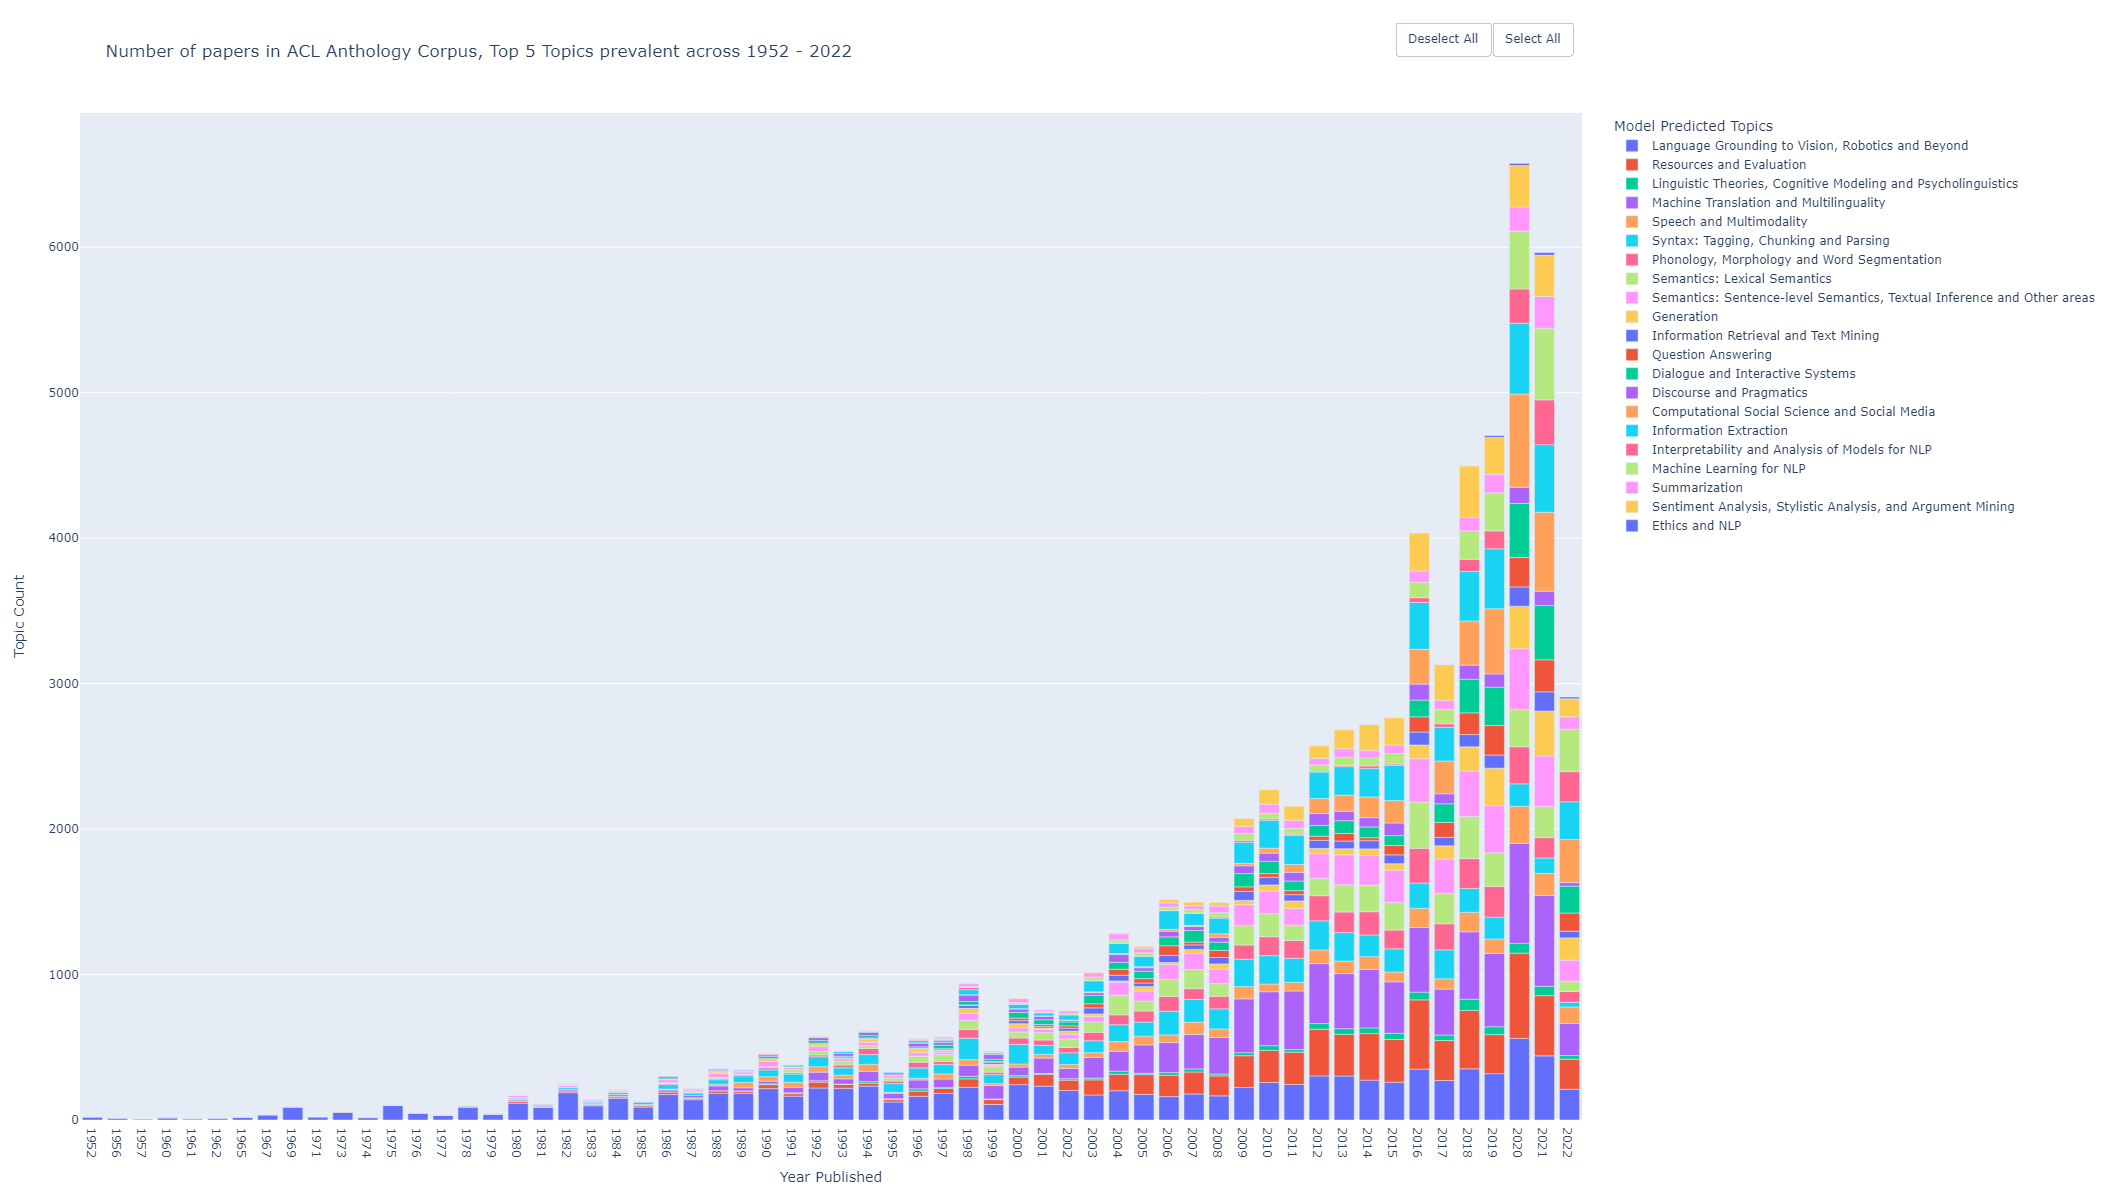

In [227]:
import plotly.express as px

fig = px.bar(year_topic_count, x="Year Published", y="Topic Count", color="Model Predicted Topics", title="Number of papers in ACL Anthology Corpus, Top 5 Topics prevalent across 1952 - 2022",
             width=1800, height=1200)

fig.update_layout(dict(updatemenus=[
                        dict(
                            type = "buttons",
                            direction = "left",
                            buttons=list([
                                dict(
                                    args=["visible", "legendonly"],
                                    label="Deselect All",
                                    method="restyle"
                                ),
                                dict(
                                    args=["visible", True],
                                    label="Select All",
                                    method="restyle"
                                )
                            ]),
                            pad={"r": 10, "t": 10},
                            showactive=False,
                            x=1,
                            xanchor="right",
                            y=1.1,
                            yanchor="top"
                        ),
                    ]
              ))

fig.show()

### Chosing the top 5 topics to display

In [95]:
year_topic_count.groupby(['Model Predicted Topics']).size().reset_index(name='Topic Appearance ac years').sort_values(by = "Topic Appearance ac years", ascending = False)

,Model Predicted Topics,Topic Appearance ac years
8,"Language Grounding to Vision, Robotics and Beyond",60
14,Resources and Evaluation,52
16,"Semantics: Sentence-level Semantics, Textual I...",50
20,"Syntax: Tagging, Chunking and Parsing",48
11,Machine Translation and Multilinguality,46
9,"Linguistic Theories, Cognitive Modeling and Ps...",45
4,Generation,43
1,Dialogue and Interactive Systems,43
12,"Phonology, Morphology and Word Segmentation",43
15,Semantics: Lexical Semantics,42


In [96]:
top_5_topics = list(year_topic_count.groupby(['Model Predicted Topics']).size().reset_index(name='Topic Appearance ac years').sort_values(by = "Topic Appearance ac years", ascending = False)['Model Predicted Topics'][0:5])

C:\Users\Benjamin Aw\AppData\Local\Temp\ipykernel_32848\1788818505.py:1: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.



In [97]:
df_plot_1 = year_topic_count[year_topic_count['Model Predicted Topics'].isin(top_5_topics)]

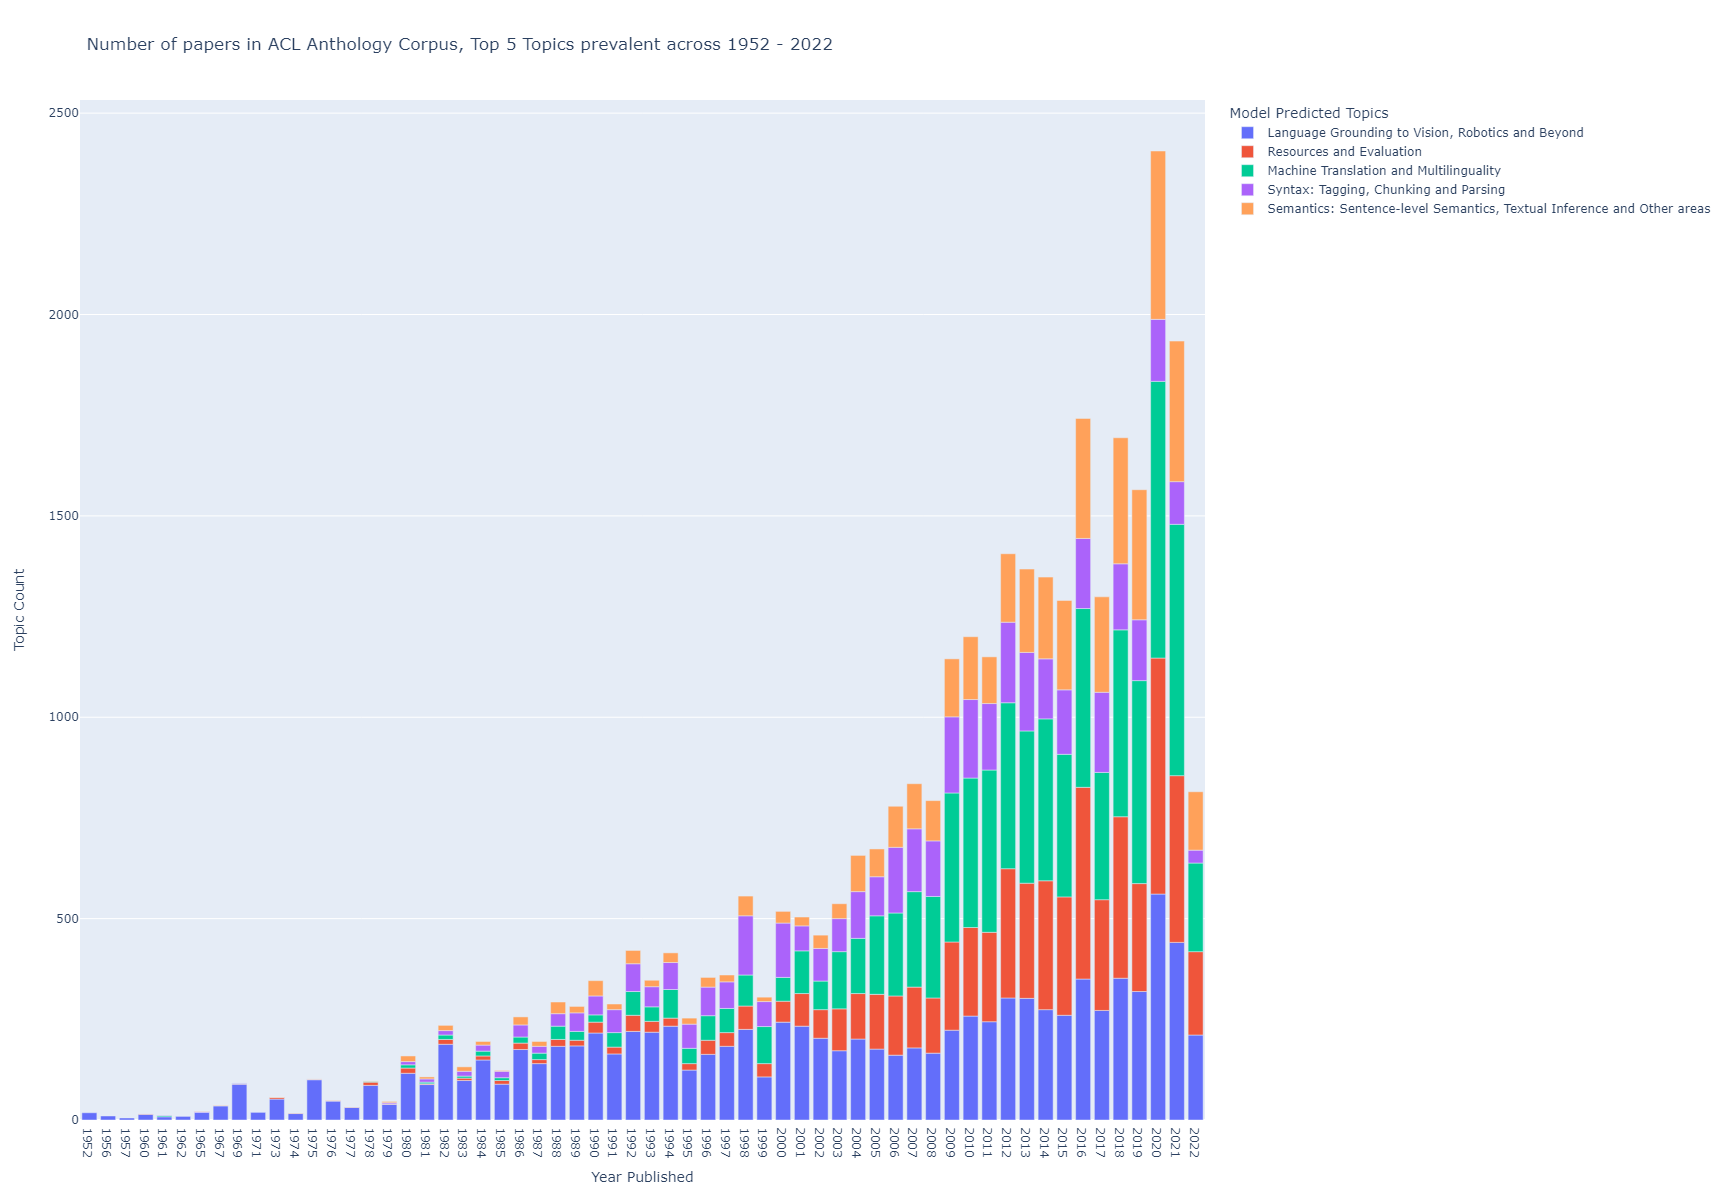

In [98]:
import plotly.express as px

fig = px.bar(df_plot_1, x="Year Published", y="Topic Count", color="Model Predicted Topics", title="Number of papers in ACL Anthology Corpus, Top 5 Topics prevalent across 1952 - 2022",
             width=1800, height=1200)
fig.show()

### Calculating burstiness of a topic

In [99]:
N_t = f_c_t.groupby('Year Published')['Topic Count'].sum()

In [100]:
N_t = N_t.reset_index(name='Paper Count')

In [101]:
f_c_t = emerge_df.groupby(['Year Published', 'Model Predicted Topics']).size().unstack(fill_value=0).stack()

In [103]:
f_c_t = f_c_t.reset_index(name='Topic Count')

In [104]:
f_c_t

,Year Published,Model Predicted Topics,Topic Count
0,1952,Computational Social Science and Social Media,0
1,1952,Dialogue and Interactive Systems,0
2,1952,Discourse and Pragmatics,0
3,1952,Ethics and NLP,0
4,1952,Generation,0
...,...,...,...
1255,2022,"Semantics: Sentence-level Semantics, Textual I...",145
1256,2022,"Sentiment Analysis, Stylistic Analysis, and Ar...",124
1257,2022,Speech and Multimodality,114
1258,2022,Summarization,85


In [112]:
N_t['Paper Count'].sum()

67732

In [113]:
pc = f_c_t.groupby('Model Predicted Topics')['Topic Count'].sum().reset_index(name='Topic count across all years')

In [115]:
pc['Pc'] = pc['Topic count across all years']/ (N_t['Paper Count'].sum())

In [116]:
pc

,Model Predicted Topics,Topic count across all years,Pc
0,Computational Social Science and Social Media,3384,0.049962
1,Dialogue and Interactive Systems,2832,0.041812
2,Discourse and Pragmatics,1586,0.023416
3,Ethics and NLP,61,0.000901
4,Generation,2032,0.030001
5,Information Extraction,4602,0.067944
6,Information Retrieval and Text Mining,1370,0.020227
7,Interpretability and Analysis of Models for NLP,1172,0.017303
8,"Language Grounding to Vision, Robotics and Beyond",9964,0.147109
9,"Linguistic Theories, Cognitive Modeling and Ps...",835,0.012328


In [122]:
f_c_t = f_c_t.merge(N_t, on = ['Year Published'], how = 'left')

In [125]:
f_c_t = f_c_t.merge(pc, on = ['Model Predicted Topics'], how = 'left')

In [129]:
z_c_t = f_c_t.drop(['Topic count across all years'], axis = 1)

In [131]:
z_c_t["Expected value"] = z_c_t['Paper Count'] * z_c_t['Pc']
z_c_t["SD value"] = z_c_t['Paper Count'] * z_c_t['Pc'] * (1 - z_c_t['Pc'])

In [135]:
z_c_t['Zct'] = (z_c_t['Topic Count'] - z_c_t['Expected value'])/z_c_t['SD value']

In [136]:
z_c_t

,Year Published,Model Predicted Topics,Topic Count,Paper Count,Pc,Expected value,SD value,Zct
0,1952,Computational Social Science and Social Media,0,18,0.049962,0.899309,0.854378,-1.052589
1,1952,Dialogue and Interactive Systems,0,18,0.041812,0.752613,0.721145,-1.043636
2,1952,Discourse and Pragmatics,0,18,0.023416,0.421485,0.411615,-1.023977
3,1952,Ethics and NLP,0,18,0.000901,0.016211,0.016196,-1.000901
4,1952,Generation,0,18,0.030001,0.540011,0.523810,-1.030928
...,...,...,...,...,...,...,...,...
1255,2022,"Semantics: Sentence-level Semantics, Textual I...",145,2908,0.063131,183.585425,171.995463,-0.224340
1256,2022,"Sentiment Analysis, Stylistic Analysis, and Ar...",124,2908,0.040572,117.982401,113.195659,0.053161
1257,2022,Speech and Multimodality,114,2908,0.033411,97.159452,93.913249,0.179320
1258,2022,Summarization,85,2908,0.022309,64.873147,63.425924,0.317328


In [138]:
z_c_t.groupby(['Year Published'])['Model Predicted Topics', 'Zct']

C:\Users\Benjamin Aw\AppData\Local\Temp\ipykernel_32848\2014691151.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [143]:
df_plot_2 = z_c_t.sort_values(['Year Published','Zct'],ascending=[True, False]).groupby('Year Published')['Year Published', 'Model Predicted Topics', 'Zct'].head(5)

C:\Users\Benjamin Aw\AppData\Local\Temp\ipykernel_32848\2116979918.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [149]:
z_c_t = z_c_t.sort_values(by="Year Published")

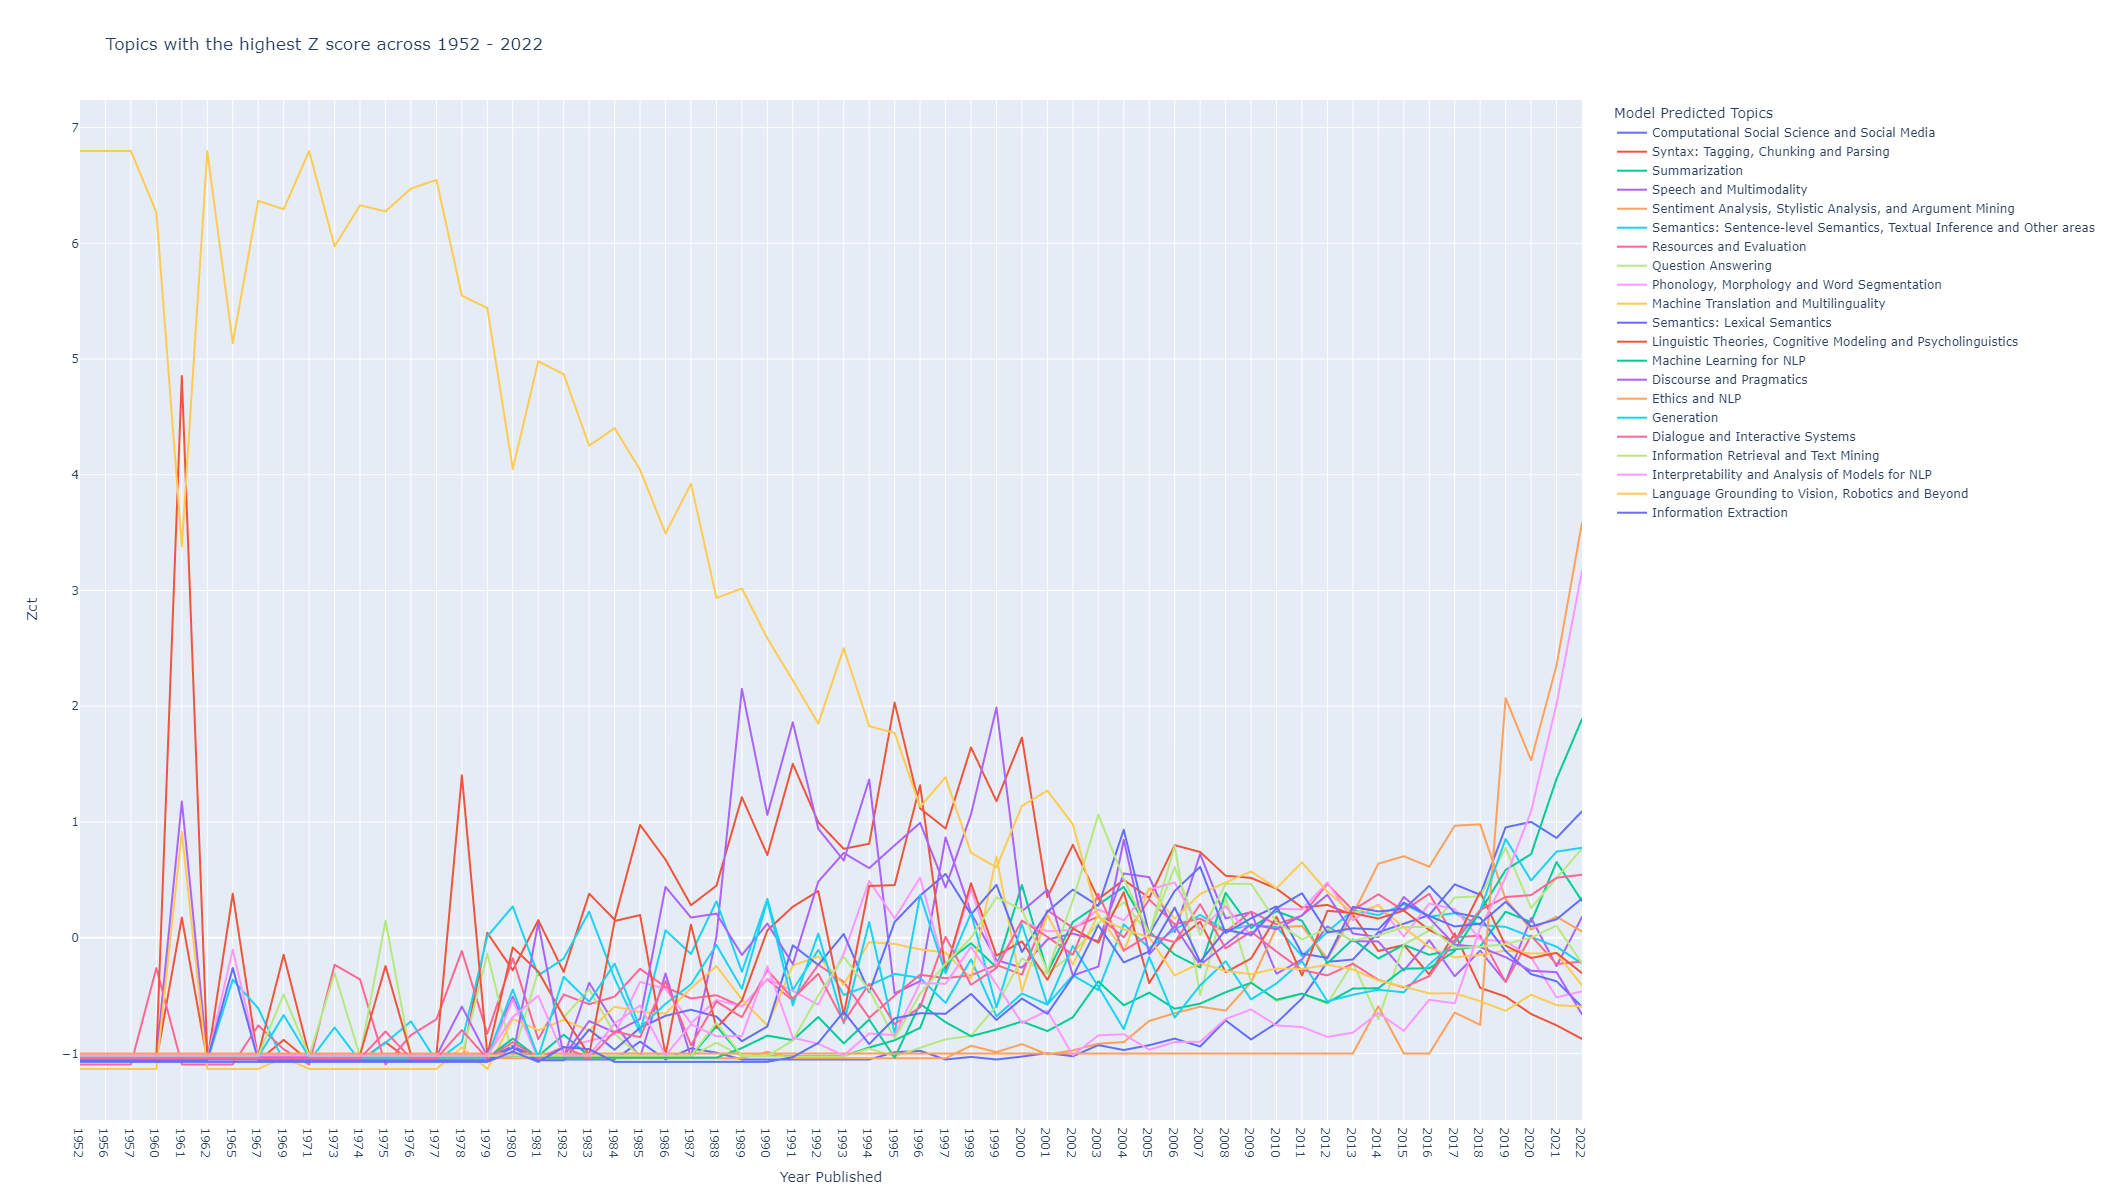

In [153]:
import plotly.express as px

fig = px.line(z_c_t, x="Year Published", y="Zct", color="Model Predicted Topics", title="Topics with the highest Z score across 1952 - 2022",
             width=1800, height=1200)

fig.update_layout(dict(updatemenus=[
                        dict(
                            type = "buttons",
                            direction = "left",
                            buttons=list([
                                dict(
                                    args=["visible", "legendonly"],
                                    label="Deselect All",
                                    method="restyle"
                                ),
                                dict(
                                    args=["visible", True],
                                    label="Select All",
                                    method="restyle"
                                )
                            ]),
                            pad={"r": 10, "t": 10},
                            showactive=False,
                            x=1,
                            xanchor="right",
                            y=1.1,
                            yanchor="top"
                        ),
                    ]
              ))

fig.show()

In [157]:
z_c_t

,Year Published,Model Predicted Topics,Topic Count,Paper Count,Pc,Expected value,SD value,Zct
0,1952,Computational Social Science and Social Media,0,18,0.049962,0.899309,0.854378,-1.052589
20,1952,"Syntax: Tagging, Chunking and Parsing",0,18,0.061433,1.105799,1.037866,-1.065454
19,1952,Summarization,0,18,0.022309,0.401553,0.392595,-1.022818
18,1952,Speech and Multimodality,0,18,0.033411,0.601400,0.581306,-1.034566
17,1952,"Sentiment Analysis, Stylistic Analysis, and Ar...",0,18,0.040572,0.730290,0.700661,-1.042287
...,...,...,...,...,...,...,...,...
1240,2022,Dialogue and Interactive Systems,185,2908,0.041812,121.588850,116.504996,0.544278
1239,2022,Computational Social Science and Social Media,296,2908,0.049962,145.288372,138.029530,1.091880
1258,2022,Summarization,85,2908,0.022309,64.873147,63.425924,0.317328
1248,2022,"Linguistic Theories, Cognitive Modeling and Ps...",25,2908,0.012328,35.849820,35.407863,-0.306424


In [159]:
z_c_t['Model Predicted Topics'].unique()

array(['Computational Social Science and Social Media',
       'Syntax: Tagging, Chunking and Parsing', 'Summarization',
       'Speech and Multimodality',
       'Sentiment Analysis, Stylistic Analysis, and Argument Mining',
       'Semantics: Sentence-level Semantics, Textual Inference and Other areas',
       'Resources and Evaluation', 'Question Answering',
       'Phonology, Morphology and Word Segmentation',
       'Machine Translation and Multilinguality',
       'Semantics: Lexical Semantics',
       'Linguistic Theories, Cognitive Modeling and Psycholinguistics',
       'Machine Learning for NLP', 'Discourse and Pragmatics',
       'Ethics and NLP', 'Generation', 'Dialogue and Interactive Systems',
       'Information Retrieval and Text Mining',
       'Interpretability and Analysis of Models for NLP',
       'Language Grounding to Vision, Robotics and Beyond',
       'Information Extraction'], dtype=object)

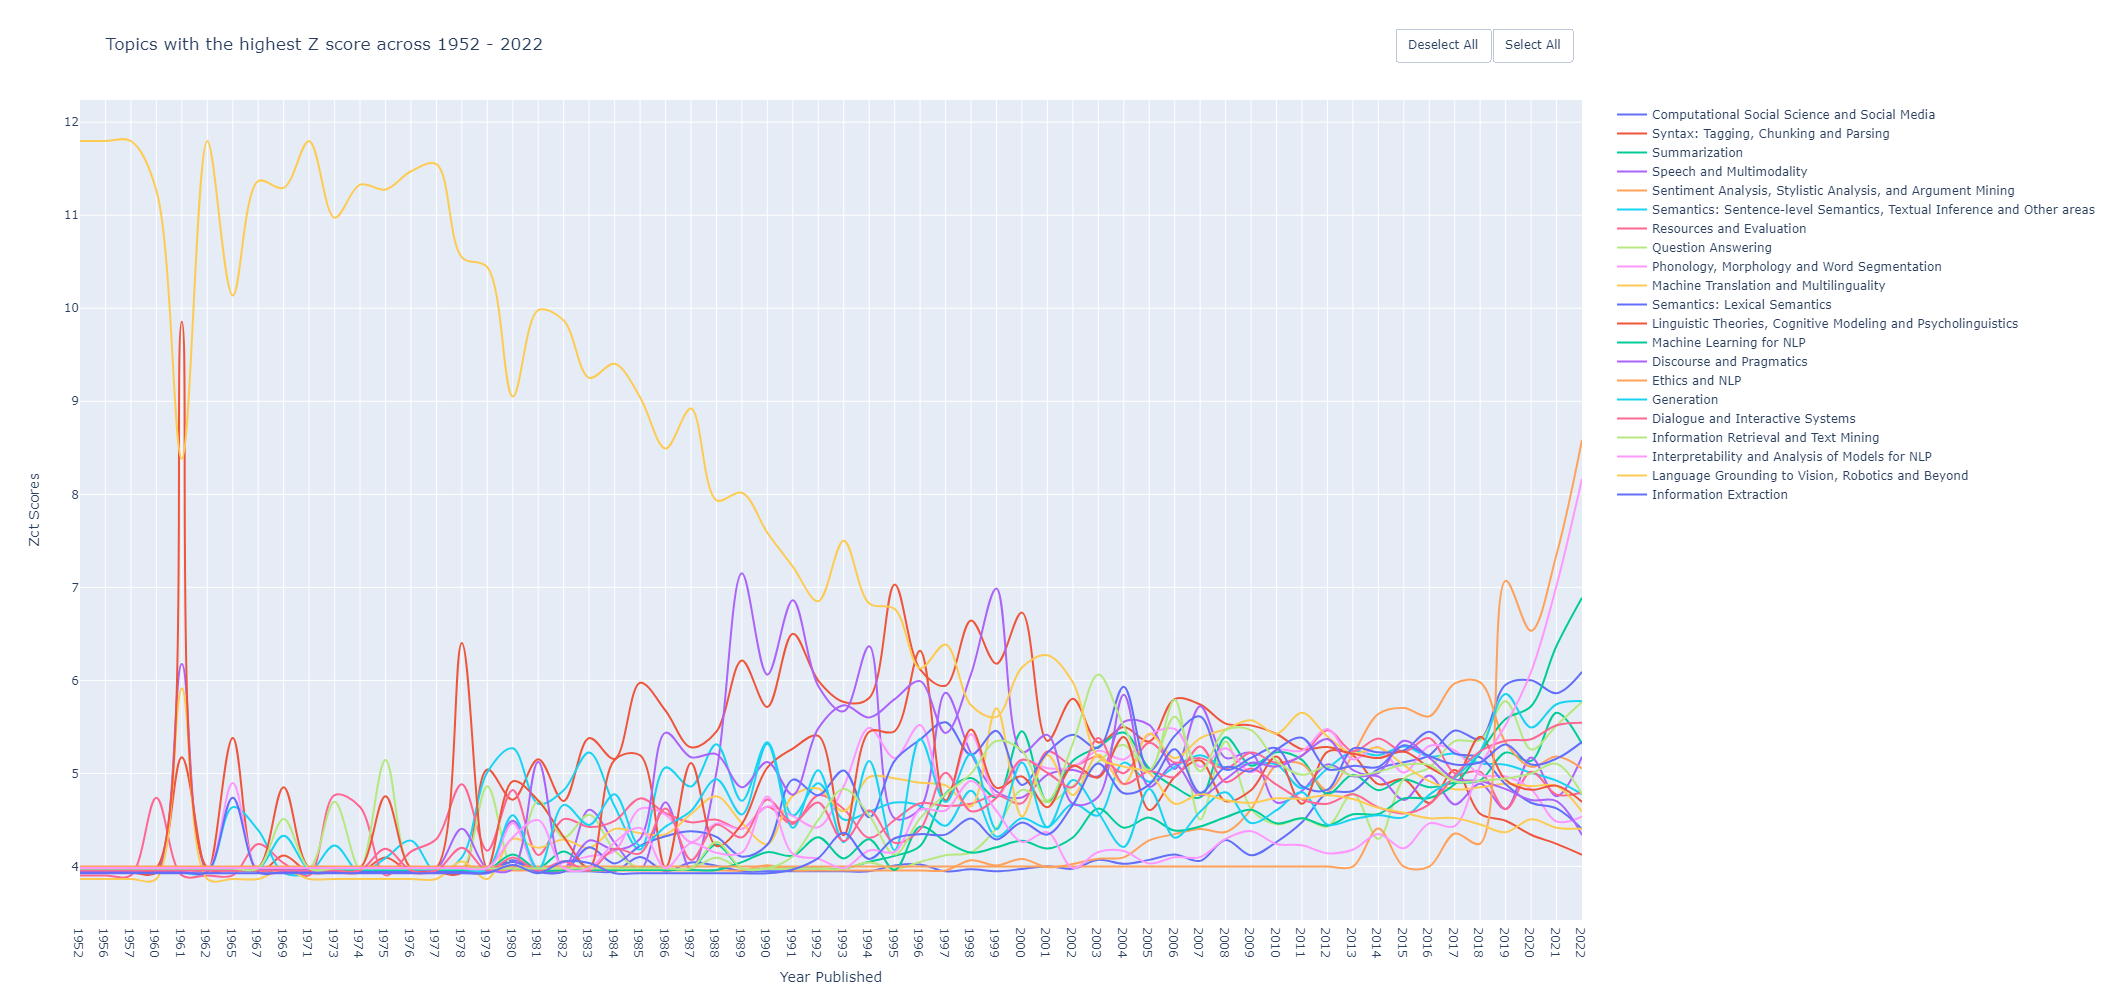

In [235]:
import plotly.graph_objects as go

fig = go.Figure()

for topic in  z_c_t['Model Predicted Topics'].unique():
    
    df = z_c_t[z_c_t['Model Predicted Topics'] == topic]
    
    x = df['Year Published'].to_numpy()
    y = df['Zct'].to_numpy()
    
    fig.add_trace(go.Scatter(x=x, y=y + 5, name = topic,
                             hoverinfo='name + y',
                             line_shape='spline'))
        
fig.update_layout(
    width=2300,
    height=1000,
    yaxis=dict(title_text="Zct Scores"),
    xaxis=dict(title_text="Year Published"),
    title="Topics with the highest Z score across 1952 - 2022"
)

fig.update_layout(dict(updatemenus=[
                        dict(
                            type = "buttons",
                            direction = "left",
                            buttons=list([
                                dict(
                                    args=["visible", "legendonly"],
                                    label="Deselect All",
                                    method="restyle"
                                ),
                                dict(
                                    args=["visible", True],
                                    label="Select All",
                                    method="restyle"
                                )
                            ]),
                            pad={"r": 10, "t": 10},
                            showactive=False,
                            x=1,
                            xanchor="right",
                            y=1.1,
                            yanchor="top"
                        ),
                    ]
              ))

### Plot top 5 topics with the widest z score with smoothing

In [221]:
Topics_of_interest = list(z_c_t.groupby('Model Predicted Topics')['Zct'].agg(np.ptp).reset_index(name = "Diff z score").nlargest(5, "Diff z score")['Model Predicted Topics'])

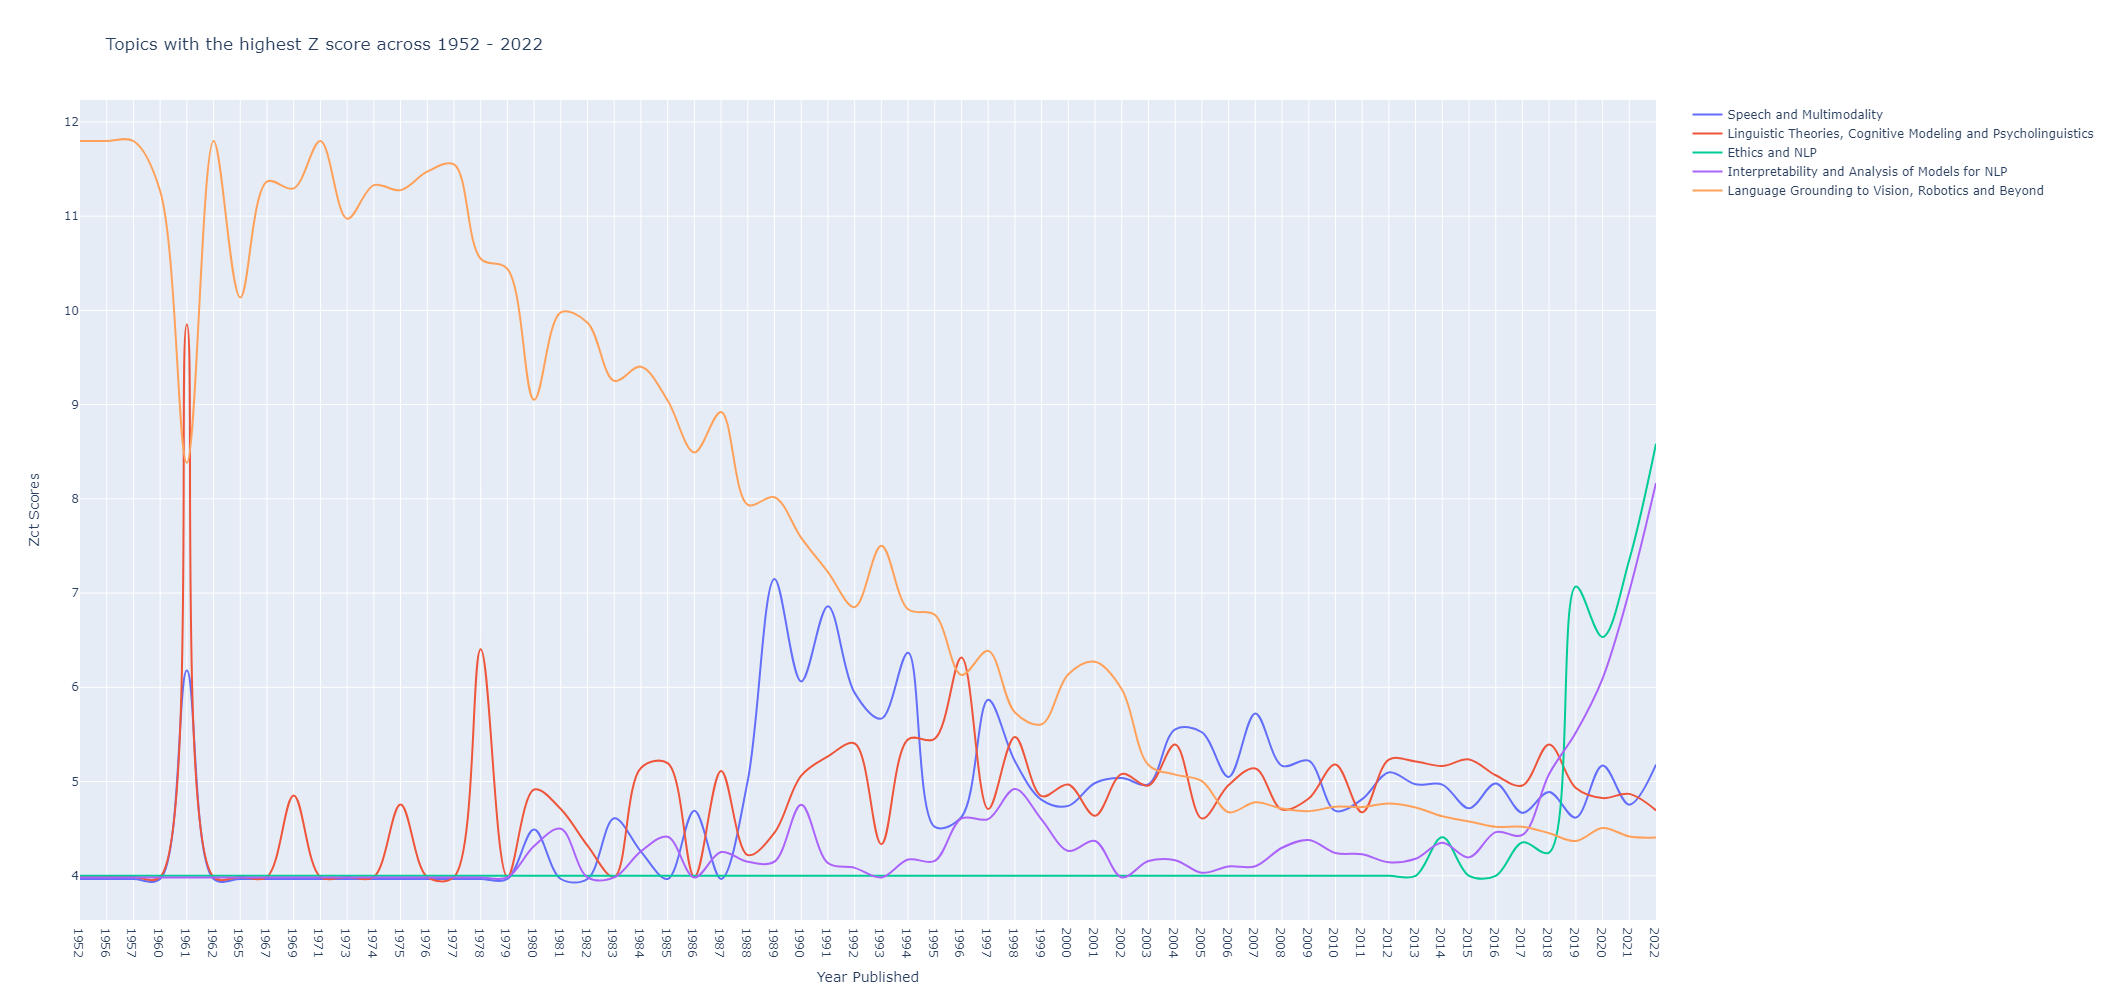

In [231]:
fig = go.Figure()

for topic in  z_c_t['Model Predicted Topics'].unique():
    
    df = z_c_t[z_c_t['Model Predicted Topics'] == topic]
    
    x = df['Year Published'].to_numpy()
    y = df['Zct'].to_numpy()
    
    if topic in Topics_of_interest:
        fig.add_trace(go.Scatter(x=x, y=y + 5, name = topic,
                                 hoverinfo='name + y',
                                 line_shape='spline'))

fig.update_layout(
    width=2300,
    height=1000,
    yaxis=dict(title_text="Zct Scores"),
    xaxis=dict(title_text="Year Published"),
    title="Topics with the highest Z score across 1952 - 2022"
)